## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("../scaled_dataset.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,0.8,143.0,210,1.72,218.0,94.6,0.434,6.255319,7,61.340426,...,95.9,1031.902128,1030.8,1034.5,256.340426,227,312,5.036170,2.2,7.4
1,16.9,143.0,210,1.72,218.0,94.6,0.434,3.375000,5,59.520833,...,84.0,1034.843750,1031.6,1038.1,317.437500,294,339,6.245833,2.0,7.6
2,1.4,143.0,210,1.72,218.0,94.6,0.434,-0.666667,2,59.916667,...,95.2,1038.256250,1037.5,1039.3,290.979167,211,345,2.154167,1.1,3.5
3,6.6,143.0,210,1.72,218.0,94.6,0.434,1.083333,3,63.166667,...,97.6,1037.075000,1035.6,1038.6,227.041667,2,359,2.637500,0.6,4.6
4,0.3,143.0,210,1.72,218.0,94.6,0.434,2.479167,4,60.812500,...,98.4,1032.722917,1031.7,1035.6,259.770833,236,287,5.212500,3.7,6.2


In [2]:
df.shape

(10871, 34)

## Preoaring the (x,y) pairs

### Scaling the data

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [4]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [5]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [6]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((10847, 24, 34), (10847,))

### Splitting the data

In [7]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((8696, 24, 34), (8696,), (1087, 24, 34), (1087,), (1064, 24, 34), (1064,))

### Plotting the splits

In [8]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

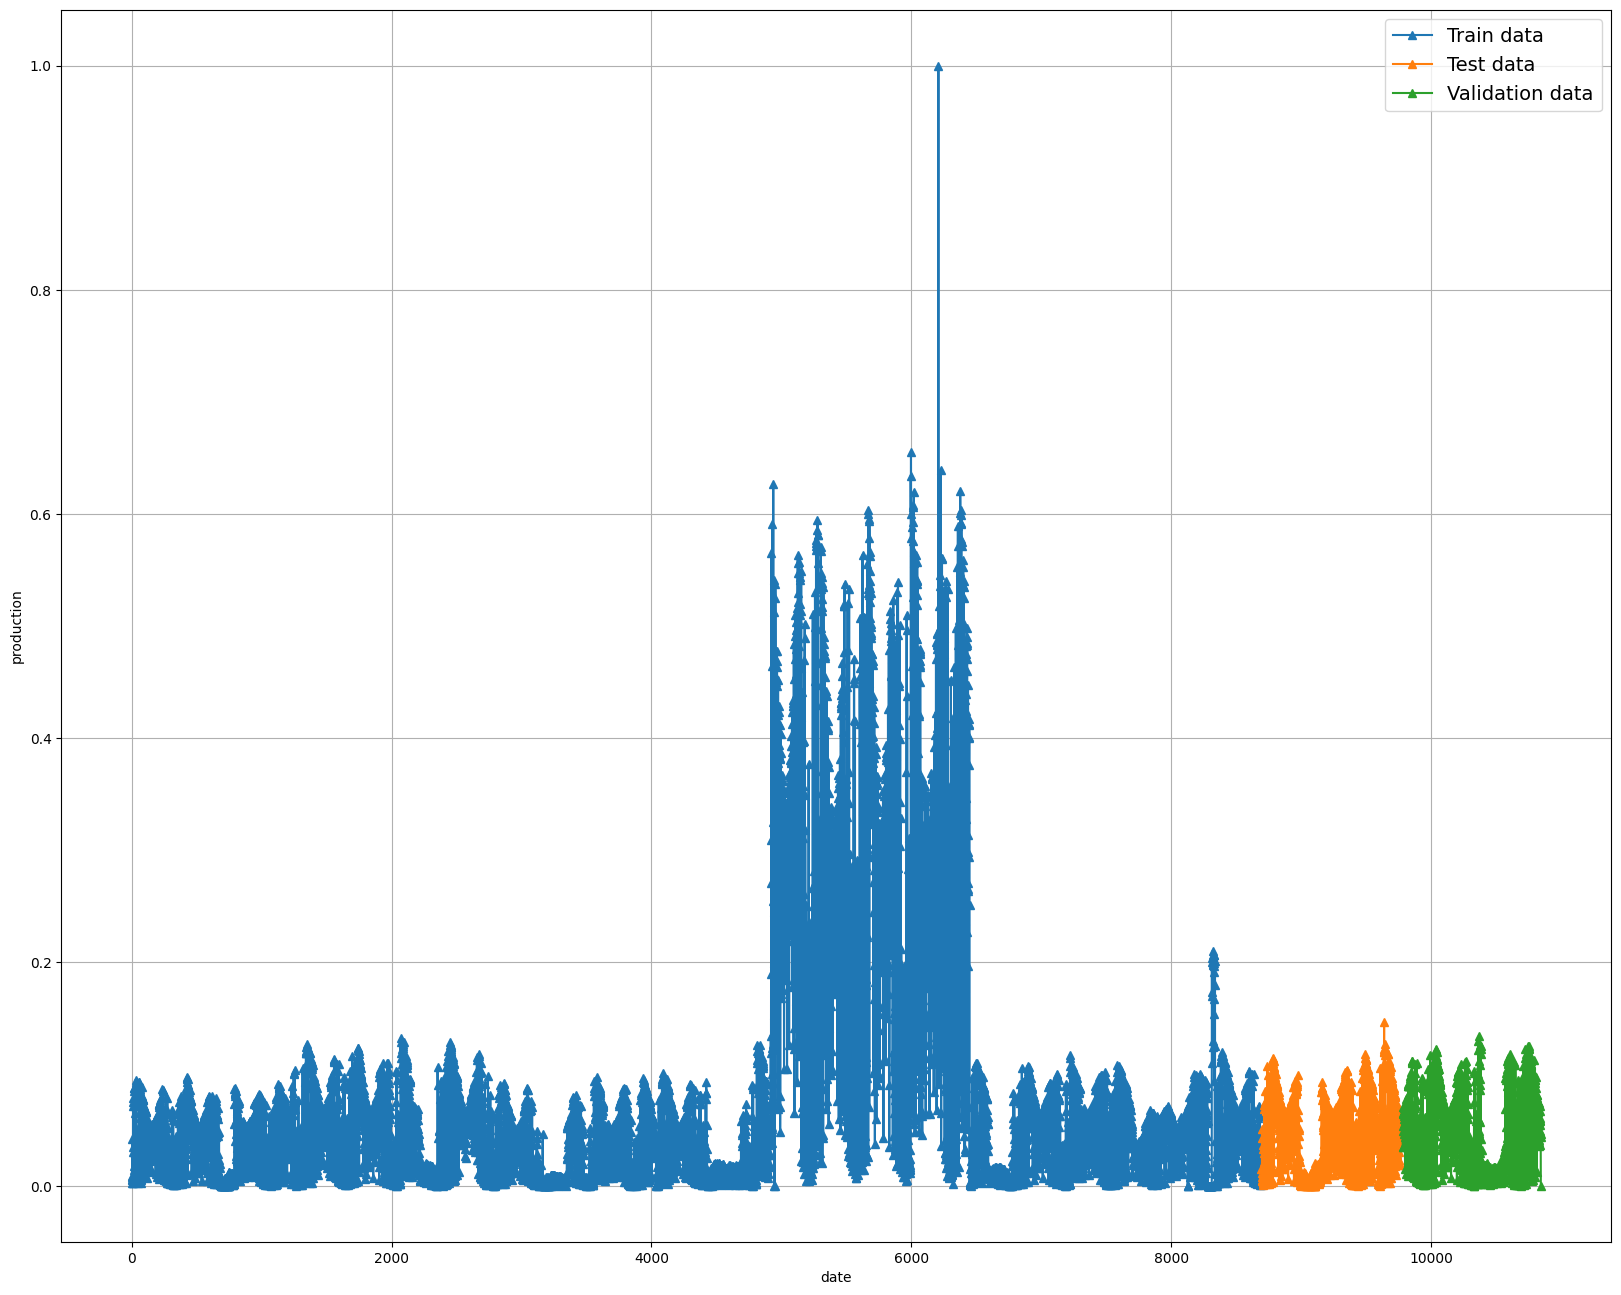

In [9]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [10]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [11]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [12]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [13]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [14]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [15]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [16]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [17]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(8696, 24, 34) -> (8696, 24, 1, 34)


In [18]:
tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=96, kernel_size=(1,), activation='tanh',
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=128, kernel_size=(1,),
               activation='relu', return_sequences=False),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000276833969681907))

conv_lstm_model.summary()

C:\Users\yhoci\blocml\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "model_conv_lstm.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm1d (ConvLSTM1D)             │ (None, 24, 1, 96)           │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)           │ (None, 1, 128)              │         115,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,825 (679.00 KB)

 Trainable params: 173,825 (679.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Training the model convlstm

In [19]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 02:49:53] [setup] RAM Tracking...
[codecarbon INFO @ 02:49:53] [setup] CPU Tracking...
[codecarbon WARNING @ 02:49:53] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 02:49:55] We saw that you have a AMD Ryzen 7 7840HS w/ Radeon 780M Graphics but we don't know it. Please contact us.
[codecarbon INFO @ 02:49:55] CPU Model on constant consumption mode: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics
[codecarbon INFO @ 02:49:55] [setup] GPU Tracking...
[codecarbon INFO @ 02:49:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:49:55] >>> Tracker's metadata:
[codecarbon INFO @ 02:49:55]   Platform system: Windows-11-10.0.26100-SP0
[codecarbon INFO @ 02:49:55]   Python version: 3.12.3
[codecarbon INFO @ 02:49:55]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 02:49:55]   Available RAM : 15.288 GB
[codecarbon INFO @ 02:49:55]   CPU count: 16
[codecarbon INFO @ 02:

In [20]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [21]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.0663 - val_loss: 0.0292
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0423 - val_loss: 0.0280
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0399 

[codecarbon INFO @ 02:50:06] Energy consumed for RAM : 0.000017 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:50:06] Energy consumed for all CPUs : 0.000123 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0399 - val_loss: 0.0274
Epoch 4/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0376

[codecarbon INFO @ 02:50:07] Energy consumed for all GPUs : 0.000008 kWh. Total GPU Power : 2.8939344658790165 W
[codecarbon INFO @ 02:50:07] 0.000148 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0390 - val_loss: 0.0275
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0385 - val_loss: 0.0272
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0383 - val_loss: 0.0271
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0379 - val_loss: 0.0268
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0376 - val_loss: 0.0264
Epoch 9/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0373 

[codecarbon INFO @ 02:50:16] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:50:16] Energy consumed for all CPUs : 0.000235 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0374

[codecarbon INFO @ 02:50:17] Energy consumed for all GPUs : 0.000018 kWh. Total GPU Power : 3.733920741781442 W
[codecarbon INFO @ 02:50:17] 0.000285 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0374 - val_loss: 0.0258
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0369 - val_loss: 0.0256
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0368 - val_loss: 0.0253
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0365 - val_loss: 0.0253
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0363 - val_loss: 0.0248
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0359 - val_loss: 0.0247
Epoch 15/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0357

[codecarbon INFO @ 02:50:26] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.732982158660889 W


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0350

[codecarbon INFO @ 02:50:26] Energy consumed for all CPUs : 0.000347 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0353

[codecarbon INFO @ 02:50:27] Energy consumed for all GPUs : 0.000030 kWh. Total GPU Power : 4.432042586063176 W
[codecarbon INFO @ 02:50:27] 0.000424 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0357 - val_loss: 0.0242
Epoch 16/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0354 - val_loss: 0.0239
Epoch 17/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0355 - val_loss: 0.0241
Epoch 18/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0348 - val_loss: 0.0233
Epoch 19/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0354 - val_loss: 0.0247
Epoch 20/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0353 

[codecarbon INFO @ 02:50:36] Energy consumed for RAM : 0.000062 kWh. RAM Power : 5.732982158660889 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0353

[codecarbon INFO @ 02:50:36] Energy consumed for all CPUs : 0.000460 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0352 - val_loss: 0.0232
Epoch 21/300


[codecarbon INFO @ 02:50:37] Energy consumed for all GPUs : 0.000041 kWh. Total GPU Power : 4.236889642717578 W
[codecarbon INFO @ 02:50:37] 0.000563 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0345 - val_loss: 0.0227
Epoch 22/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0343 - val_loss: 0.0228
Epoch 23/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0345 - val_loss: 0.0226
Epoch 24/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0341 - val_loss: 0.0224
Epoch 25/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0337 - val_loss: 0.0221
Epoch 26/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0333 

[codecarbon INFO @ 02:50:46] Energy consumed for RAM : 0.000077 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:50:46] Energy consumed for all CPUs : 0.000573 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0335

[codecarbon INFO @ 02:50:47] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 4.254245868111433 W
[codecarbon INFO @ 02:50:47] 0.000703 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0335 - val_loss: 0.0222
Epoch 27/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0334 - val_loss: 0.0226
Epoch 28/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0333 - val_loss: 0.0225
Epoch 29/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0330 - val_loss: 0.0216
Epoch 30/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0327 - val_loss: 0.0216
Epoch 31/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0329 - val_loss: 0.0219
Epoch 32/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0327

[codecarbon INFO @ 02:50:56] Energy consumed for RAM : 0.000092 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:50:56] Energy consumed for all CPUs : 0.000686 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0335 

[codecarbon INFO @ 02:50:57] Energy consumed for all GPUs : 0.000061 kWh. Total GPU Power : 3.331823797418701 W
[codecarbon INFO @ 02:50:57] 0.000839 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0336 - val_loss: 0.0217
Epoch 33/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0325 - val_loss: 0.0212
Epoch 34/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0324 - val_loss: 0.0211
Epoch 35/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0323 - val_loss: 0.0210
Epoch 36/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0321 - val_loss: 0.0210
Epoch 37/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0326 

[codecarbon INFO @ 02:51:06] Energy consumed for RAM : 0.000107 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:51:06] Energy consumed for all CPUs : 0.000798 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0326 - val_loss: 0.0209
Epoch 38/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0321

[codecarbon INFO @ 02:51:07] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 3.687813718800755 W
[codecarbon INFO @ 02:51:07] 0.000977 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0319 - val_loss: 0.0206
Epoch 39/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0319 - val_loss: 0.0211
Epoch 40/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0319 - val_loss: 0.0204
Epoch 41/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0330 - val_loss: 0.0225
Epoch 42/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0332 - val_loss: 0.0227
Epoch 43/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0321 

[codecarbon INFO @ 02:51:16] Energy consumed for RAM : 0.000122 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:51:16] Energy consumed for all CPUs : 0.000911 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0322

[codecarbon INFO @ 02:51:17] Energy consumed for all GPUs : 0.000080 kWh. Total GPU Power : 3.424882945186054 W
[codecarbon INFO @ 02:51:17] 0.001113 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0321 - val_loss: 0.0209
Epoch 44/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0312 

[codecarbon INFO @ 02:51:17] 0.000220 g.CO2eq/s mean an estimation of 6.937444876923425 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0325 - val_loss: 0.0212
Epoch 45/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0323 - val_loss: 0.0211
Epoch 46/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0316 - val_loss: 0.0204
Epoch 47/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0314 - val_loss: 0.0204
Epoch 48/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0313 - val_loss: 0.0200
Epoch 49/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0305

[codecarbon INFO @ 02:51:26] Energy consumed for RAM : 0.000138 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:51:26] Energy consumed for all CPUs : 0.001024 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0304 

[codecarbon INFO @ 02:51:27] Energy consumed for all GPUs : 0.000091 kWh. Total GPU Power : 4.0926044952865235 W
[codecarbon INFO @ 02:51:27] 0.001252 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0309 - val_loss: 0.0201
Epoch 50/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0307 - val_loss: 0.0199
Epoch 51/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0305 - val_loss: 0.0197
Epoch 52/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0306 - val_loss: 0.0199
Epoch 53/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0307 - val_loss: 0.0198
Epoch 54/300
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0304 

[codecarbon INFO @ 02:51:36] Energy consumed for RAM : 0.000153 kWh. RAM Power : 5.732982158660889 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0305

[codecarbon INFO @ 02:51:36] Energy consumed for all CPUs : 0.001136 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0305

[codecarbon INFO @ 02:51:37] Energy consumed for all GPUs : 0.000102 kWh. Total GPU Power : 4.289359440268008 W
[codecarbon INFO @ 02:51:37] 0.001391 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0305 - val_loss: 0.0198
Epoch 55/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0303 - val_loss: 0.0195
Epoch 56/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0305 - val_loss: 0.0197
Epoch 57/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0311 - val_loss: 0.0206
Epoch 58/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0315 - val_loss: 0.0202
Epoch 59/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0309 - val_loss: 0.0201
Epoch 60/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0304 

[codecarbon INFO @ 02:51:46] Energy consumed for RAM : 0.000168 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:51:46] Energy consumed for all CPUs : 0.001249 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0307

[codecarbon INFO @ 02:51:47] Energy consumed for all GPUs : 0.000112 kWh. Total GPU Power : 3.446127265600536 W
[codecarbon INFO @ 02:51:47] 0.001529 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0307 - val_loss: 0.0196
Epoch 61/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0304 - val_loss: 0.0194
Epoch 62/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0300 - val_loss: 0.0193
Epoch 63/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0301 - val_loss: 0.0196
Epoch 64/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0296 - val_loss: 0.0193
Epoch 65/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0297 

[codecarbon INFO @ 02:51:56] Energy consumed for RAM : 0.000183 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:51:56] Energy consumed for all CPUs : 0.001362 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0297 - val_loss: 0.0193
Epoch 66/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0286 

[codecarbon INFO @ 02:51:57] Energy consumed for all GPUs : 0.000121 kWh. Total GPU Power : 3.4273386014372855 W
[codecarbon INFO @ 02:51:57] 0.001666 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0297 - val_loss: 0.0192
Epoch 67/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0296 - val_loss: 0.0191
Epoch 68/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0294 - val_loss: 0.0194
Epoch 69/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0297 - val_loss: 0.0193
Epoch 70/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0294 - val_loss: 0.0192
Epoch 71/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0296 

[codecarbon INFO @ 02:52:06] Energy consumed for RAM : 0.000198 kWh. RAM Power : 5.732982158660889 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0297

[codecarbon INFO @ 02:52:06] Energy consumed for all CPUs : 0.001475 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0297

[codecarbon INFO @ 02:52:07] Energy consumed for all GPUs : 0.000129 kWh. Total GPU Power : 3.3028032281820194 W
[codecarbon INFO @ 02:52:07] 0.001802 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0297 - val_loss: 0.0192
Epoch 72/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0294 - val_loss: 0.0190
Epoch 73/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0293 - val_loss: 0.0190
Epoch 74/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0293 - val_loss: 0.0193
Epoch 75/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0291 - val_loss: 0.0189
Epoch 76/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0290 - val_loss: 0.0191
Epoch 77/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0286 

[codecarbon INFO @ 02:52:16] Energy consumed for RAM : 0.000213 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:52:16] Energy consumed for all CPUs : 0.001587 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0289

[codecarbon INFO @ 02:52:17] Energy consumed for all GPUs : 0.000139 kWh. Total GPU Power : 3.5191243434865136 W
[codecarbon INFO @ 02:52:17] 0.001940 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0291 - val_loss: 0.0188
Epoch 78/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0290 - val_loss: 0.0188
Epoch 79/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0288 - val_loss: 0.0192
Epoch 80/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0286 - val_loss: 0.0189
Epoch 81/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0288 - val_loss: 0.0189
Epoch 82/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0286 - val_loss: 0.0194
Epoch 83/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0278

[codecarbon INFO @ 02:52:26] Energy consumed for RAM : 0.000229 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:52:26] Energy consumed for all CPUs : 0.001700 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0281 

[codecarbon INFO @ 02:52:27] Energy consumed for all GPUs : 0.000149 kWh. Total GPU Power : 3.983674894271389 W
[codecarbon INFO @ 02:52:27] 0.002078 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0286 - val_loss: 0.0193
Epoch 84/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0287 - val_loss: 0.0190
Epoch 85/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0286 - val_loss: 0.0192
Epoch 86/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0288 - val_loss: 0.0190
Epoch 87/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0288 - val_loss: 0.0188
Epoch 88/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0288 

[codecarbon INFO @ 02:52:36] Energy consumed for RAM : 0.000244 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:52:36] Energy consumed for all CPUs : 0.001813 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0288 - val_loss: 0.0188
Epoch 89/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0278

[codecarbon INFO @ 02:52:37] Energy consumed for all GPUs : 0.000159 kWh. Total GPU Power : 3.5725873431656137 W
[codecarbon INFO @ 02:52:37] 0.002216 kWh of electricity used since the beginning.


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0282 

[codecarbon INFO @ 02:52:37] 0.000220 g.CO2eq/s mean an estimation of 6.945060517821011 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0288 - val_loss: 0.0188
Epoch 90/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0283 - val_loss: 0.0192
Epoch 91/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0283 - val_loss: 0.0193
Epoch 92/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0288 - val_loss: 0.0186
Epoch 93/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0285 - val_loss: 0.0187
Epoch 94/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0286

[codecarbon INFO @ 02:52:46] Energy consumed for RAM : 0.000259 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:52:46] Energy consumed for all CPUs : 0.001926 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0291

[codecarbon INFO @ 02:52:47] Energy consumed for all GPUs : 0.000170 kWh. Total GPU Power : 4.18325656071107 W
[codecarbon INFO @ 02:52:47] 0.002355 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0291 - val_loss: 0.0190
Epoch 95/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0288 - val_loss: 0.0200
Epoch 96/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0285 - val_loss: 0.0193
Epoch 97/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0283 - val_loss: 0.0186
Epoch 98/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0281 - val_loss: 0.0186
Epoch 99/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0282 - val_loss: 0.0187
Epoch 100/300


[codecarbon INFO @ 02:52:56] Energy consumed for RAM : 0.000274 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:52:56] Energy consumed for all CPUs : 0.002039 kWh. Total CPU Power : 42.5 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0272 

[codecarbon INFO @ 02:52:57] Energy consumed for all GPUs : 0.000181 kWh. Total GPU Power : 4.2531132384982495 W
[codecarbon INFO @ 02:52:57] 0.002494 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0279 - val_loss: 0.0190
Epoch 101/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0280 - val_loss: 0.0190
Epoch 102/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0279 - val_loss: 0.0188
Epoch 103/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0279 - val_loss: 0.0193
Epoch 104/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0280 - val_loss: 0.0190
Epoch 105/300
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0281 

[codecarbon INFO @ 02:53:06] Energy consumed for RAM : 0.000289 kWh. RAM Power : 5.732982158660889 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0281

[codecarbon INFO @ 02:53:06] Energy consumed for all CPUs : 0.002152 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0281 - val_loss: 0.0195
Epoch 106/300


[codecarbon INFO @ 02:53:07] Energy consumed for all GPUs : 0.000191 kWh. Total GPU Power : 3.5122684937486963 W
[codecarbon INFO @ 02:53:07] 0.002631 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0283 - val_loss: 0.0186
Epoch 107/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0283 - val_loss: 0.0190
Epoch 108/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0283 - val_loss: 0.0186
Epoch 109/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0279 - val_loss: 0.0185
Epoch 110/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0277 - val_loss: 0.0190
Epoch 111/300
 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0272

[codecarbon INFO @ 02:53:16] Energy consumed for RAM : 0.000304 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:53:16] Energy consumed for all CPUs : 0.002265 kWh. Total CPU Power : 42.5 W


10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0276

[codecarbon INFO @ 02:53:17] Energy consumed for all GPUs : 0.000201 kWh. Total GPU Power : 3.86637742913557 W
[codecarbon INFO @ 02:53:17] 0.002770 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0277 - val_loss: 0.0188
Epoch 112/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0276 - val_loss: 0.0188
Epoch 113/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0276 - val_loss: 0.0199
Epoch 114/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0278 - val_loss: 0.0187
Epoch 115/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0281 - val_loss: 0.0182
Epoch 116/300
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0279 

[codecarbon INFO @ 02:53:26] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:53:26] Energy consumed for all CPUs : 0.002377 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0279

[codecarbon INFO @ 02:53:27] Energy consumed for all GPUs : 0.000212 kWh. Total GPU Power : 4.32189839384828 W
[codecarbon INFO @ 02:53:27] 0.002909 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0279 - val_loss: 0.0184
Epoch 117/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0276 - val_loss: 0.0193
Epoch 118/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0282 - val_loss: 0.0183
Epoch 119/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0278 - val_loss: 0.0190
Epoch 120/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0277 - val_loss: 0.0180
Epoch 121/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0276 - val_loss: 0.0181
Epoch 122/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0275 

[codecarbon INFO @ 02:53:36] Energy consumed for RAM : 0.000334 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:53:36] Energy consumed for all CPUs : 0.002490 kWh. Total CPU Power : 42.5 W


 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0283

[codecarbon INFO @ 02:53:37] Energy consumed for all GPUs : 0.000221 kWh. Total GPU Power : 3.4291491000030323 W
[codecarbon INFO @ 02:53:37] 0.003046 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0287 - val_loss: 0.0189
Epoch 123/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0283 - val_loss: 0.0191
Epoch 124/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0285 - val_loss: 0.0190
Epoch 125/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0282 - val_loss: 0.0182
Epoch 126/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0274 - val_loss: 0.0177
Epoch 127/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0271

[codecarbon INFO @ 02:53:46] Energy consumed for RAM : 0.000350 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:53:46] Energy consumed for all CPUs : 0.002602 kWh. Total CPU Power : 42.5 W


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0272

[codecarbon INFO @ 02:53:47] Energy consumed for all GPUs : 0.000231 kWh. Total GPU Power : 3.5293141749323764 W
[codecarbon INFO @ 02:53:47] 0.003183 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0271 - val_loss: 0.0178
Epoch 128/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0271 - val_loss: 0.0182
Epoch 129/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0270 - val_loss: 0.0189
Epoch 130/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0268 - val_loss: 0.0184
Epoch 131/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0267 - val_loss: 0.0178
Epoch 132/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0269 - val_loss: 0.0178
Epoch 133/300


[codecarbon INFO @ 02:53:56] Energy consumed for RAM : 0.000365 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:53:56] Energy consumed for all CPUs : 0.002715 kWh. Total CPU Power : 42.5 W


 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0260 

[codecarbon INFO @ 02:53:57] Energy consumed for all GPUs : 0.000241 kWh. Total GPU Power : 3.8735649326975623 W
[codecarbon INFO @ 02:53:57] 0.003321 kWh of electricity used since the beginning.


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0266 

[codecarbon INFO @ 02:53:57] 0.000221 g.CO2eq/s mean an estimation of 6.961170136486396 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0268 - val_loss: 0.0178
Epoch 134/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0264 - val_loss: 0.0177
Epoch 135/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0265 - val_loss: 0.0177
Epoch 136/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0268 - val_loss: 0.0178
Epoch 137/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0270 - val_loss: 0.0174
Epoch 138/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0267 

[codecarbon INFO @ 02:54:06] Energy consumed for RAM : 0.000380 kWh. RAM Power : 5.732982158660889 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0268

[codecarbon INFO @ 02:54:06] Energy consumed for all CPUs : 0.002828 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0268

[codecarbon INFO @ 02:54:07] Energy consumed for all GPUs : 0.000252 kWh. Total GPU Power : 4.002222229885243 W
[codecarbon INFO @ 02:54:07] 0.003459 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0268 - val_loss: 0.0177
Epoch 139/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0266 - val_loss: 0.0177
Epoch 140/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0265 - val_loss: 0.0182
Epoch 141/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0267 - val_loss: 0.0177
Epoch 142/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0266 - val_loss: 0.0176
Epoch 143/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0267 - val_loss: 0.0177
Epoch 144/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0264 

[codecarbon INFO @ 02:54:16] Energy consumed for RAM : 0.000395 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:54:16] Energy consumed for all CPUs : 0.002940 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0269

[codecarbon INFO @ 02:54:17] Energy consumed for all GPUs : 0.000262 kWh. Total GPU Power : 4.0584103412563275 W
[codecarbon INFO @ 02:54:17] 0.003598 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0269 - val_loss: 0.0174
Epoch 145/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0274 - val_loss: 0.0186
Epoch 146/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0277 - val_loss: 0.0179
Epoch 147/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0270 - val_loss: 0.0178
Epoch 148/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0268 - val_loss: 0.0177
Epoch 149/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0262 

[codecarbon INFO @ 02:54:26] Energy consumed for RAM : 0.000410 kWh. RAM Power : 5.732982158660889 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0262

[codecarbon INFO @ 02:54:26] Energy consumed for all CPUs : 0.003053 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0262 - val_loss: 0.0174
Epoch 150/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0252

[codecarbon INFO @ 02:54:27] Energy consumed for all GPUs : 0.000272 kWh. Total GPU Power : 3.5356528018440514 W
[codecarbon INFO @ 02:54:27] 0.003734 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0257 - val_loss: 0.0173
Epoch 151/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0267 - val_loss: 0.0176
Epoch 152/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0262 - val_loss: 0.0171
Epoch 153/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0262 - val_loss: 0.0172
Epoch 154/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0267 - val_loss: 0.0182
Epoch 155/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0273 

[codecarbon INFO @ 02:54:36] Energy consumed for RAM : 0.000425 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:54:36] Energy consumed for all CPUs : 0.003165 kWh. Total CPU Power : 42.5 W


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0274

[codecarbon INFO @ 02:54:37] Energy consumed for all GPUs : 0.000281 kWh. Total GPU Power : 3.603833877002715 W
[codecarbon INFO @ 02:54:37] 0.003872 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0274 - val_loss: 0.0179
Epoch 156/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0268 - val_loss: 0.0175
Epoch 157/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0260 - val_loss: 0.0173
Epoch 158/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0257 - val_loss: 0.0171
Epoch 159/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0256 - val_loss: 0.0172
Epoch 160/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0254 

[codecarbon INFO @ 02:54:46] Energy consumed for RAM : 0.000440 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:54:46] Energy consumed for all CPUs : 0.003278 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0253 - val_loss: 0.0172
Epoch 161/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0251

[codecarbon INFO @ 02:54:47] Energy consumed for all GPUs : 0.000293 kWh. Total GPU Power : 4.4558383203416225 W


 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0247 

[codecarbon INFO @ 02:54:47] 0.004012 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0253 - val_loss: 0.0173
Epoch 162/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0256 - val_loss: 0.0170
Epoch 163/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0258 - val_loss: 0.0194
Epoch 164/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0273 - val_loss: 0.0183
Epoch 165/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0259 - val_loss: 0.0172
Epoch 166/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0255 

[codecarbon INFO @ 02:54:56] Energy consumed for RAM : 0.000455 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:54:56] Energy consumed for all CPUs : 0.003390 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0255

[codecarbon INFO @ 02:54:57] Energy consumed for all GPUs : 0.000303 kWh. Total GPU Power : 3.8030804045119515 W
[codecarbon INFO @ 02:54:57] 0.004149 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0254 - val_loss: 0.0174
Epoch 167/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0252 - val_loss: 0.0176
Epoch 168/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0253 - val_loss: 0.0172
Epoch 169/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0252 - val_loss: 0.0172
Epoch 170/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0253 - val_loss: 0.0175
Epoch 171/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0253 - val_loss: 0.0176
Epoch 172/300


[codecarbon INFO @ 02:55:06] Energy consumed for RAM : 0.000471 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:55:06] Energy consumed for all CPUs : 0.003503 kWh. Total CPU Power : 42.5 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0255 

[codecarbon INFO @ 02:55:07] Energy consumed for all GPUs : 0.000313 kWh. Total GPU Power : 3.7122884248878925 W
[codecarbon INFO @ 02:55:07] 0.004287 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0254 - val_loss: 0.0173
Epoch 173/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0253 - val_loss: 0.0172
Epoch 174/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0252 - val_loss: 0.0175
Epoch 175/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0253 - val_loss: 0.0172
Epoch 176/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0252 - val_loss: 0.0173
Epoch 177/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0256 

[codecarbon INFO @ 02:55:16] Energy consumed for RAM : 0.000486 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:55:16] Energy consumed for all CPUs : 0.003616 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0256

[codecarbon INFO @ 02:55:17] Energy consumed for all GPUs : 0.000322 kWh. Total GPU Power : 3.4651069607124434 W
[codecarbon INFO @ 02:55:17] 0.004424 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0256 - val_loss: 0.0180
Epoch 178/300


[codecarbon INFO @ 02:55:17] 0.000220 g.CO2eq/s mean an estimation of 6.950867883282815 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0257 - val_loss: 0.0171
Epoch 179/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0254 - val_loss: 0.0173
Epoch 180/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0252 - val_loss: 0.0170
Epoch 181/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0249 - val_loss: 0.0178
Epoch 182/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0253 - val_loss: 0.0173
Epoch 183/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0244 

[codecarbon INFO @ 02:55:26] Energy consumed for RAM : 0.000501 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:55:26] Energy consumed for all CPUs : 0.003728 kWh. Total CPU Power : 42.5 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0251 

[codecarbon INFO @ 02:55:27] Energy consumed for all GPUs : 0.000331 kWh. Total GPU Power : 3.3740533007445586 W
[codecarbon INFO @ 02:55:27] 0.004560 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0251 - val_loss: 0.0172
Epoch 184/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0247 - val_loss: 0.0170
Epoch 185/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0252 - val_loss: 0.0174
Epoch 186/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0258 - val_loss: 0.0189
Epoch 187/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0262 - val_loss: 0.0184
Epoch 188/300
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0260 

[codecarbon INFO @ 02:55:36] Energy consumed for RAM : 0.000516 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:55:36] Energy consumed for all CPUs : 0.003841 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0260 - val_loss: 0.0179
Epoch 189/300
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0259

[codecarbon INFO @ 02:55:37] Energy consumed for all GPUs : 0.000340 kWh. Total GPU Power : 3.407905580878142 W
[codecarbon INFO @ 02:55:37] 0.004697 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0255 - val_loss: 0.0170
Epoch 190/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0250 - val_loss: 0.0180
Epoch 191/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0256 - val_loss: 0.0173
Epoch 192/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0256 - val_loss: 0.0176
Epoch 193/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0254 - val_loss: 0.0173
Epoch 194/300
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0252 

[codecarbon INFO @ 02:55:46] Energy consumed for RAM : 0.000531 kWh. RAM Power : 5.732982158660889 W


 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0252

[codecarbon INFO @ 02:55:46] Energy consumed for all CPUs : 0.003954 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0251

[codecarbon INFO @ 02:55:47] Energy consumed for all GPUs : 0.000349 kWh. Total GPU Power : 3.317083247465023 W
[codecarbon INFO @ 02:55:47] 0.004834 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0251 - val_loss: 0.0178
Epoch 195/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0255 - val_loss: 0.0171
Epoch 196/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0255 - val_loss: 0.0170
Epoch 197/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0249 - val_loss: 0.0173
Epoch 198/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0252 - val_loss: 0.0168
Epoch 199/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0244 

[codecarbon INFO @ 02:55:56] Energy consumed for RAM : 0.000546 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:55:56] Energy consumed for all CPUs : 0.004067 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0244 - val_loss: 0.0167
Epoch 200/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0236 

[codecarbon INFO @ 02:55:57] Energy consumed for all GPUs : 0.000360 kWh. Total GPU Power : 4.234182759611105 W
[codecarbon INFO @ 02:55:57] 0.004973 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0244 - val_loss: 0.0167
Epoch 201/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0245 - val_loss: 0.0163
Epoch 202/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0244 - val_loss: 0.0166
Epoch 203/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0242 - val_loss: 0.0165
Epoch 204/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0243 - val_loss: 0.0169
Epoch 205/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0247 

[codecarbon INFO @ 02:56:06] Energy consumed for RAM : 0.000561 kWh. RAM Power : 5.732982158660889 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0247

[codecarbon INFO @ 02:56:06] Energy consumed for all CPUs : 0.004179 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0247

[codecarbon INFO @ 02:56:07] Energy consumed for all GPUs : 0.000370 kWh. Total GPU Power : 3.8373455693598264 W
[codecarbon INFO @ 02:56:07] 0.005111 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0247 - val_loss: 0.0170
Epoch 206/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0246 - val_loss: 0.0169
Epoch 207/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0246 - val_loss: 0.0169
Epoch 208/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0249 - val_loss: 0.0173
Epoch 209/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0251 - val_loss: 0.0172
Epoch 210/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0250 - val_loss: 0.0166
Epoch 211/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0242 

[codecarbon INFO @ 02:56:16] Energy consumed for RAM : 0.000577 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:56:16] Energy consumed for all CPUs : 0.004292 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0245

[codecarbon INFO @ 02:56:17] Energy consumed for all GPUs : 0.000380 kWh. Total GPU Power : 3.5743681440910633 W
[codecarbon INFO @ 02:56:17] 0.005249 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0243 - val_loss: 0.0171
Epoch 212/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0240 - val_loss: 0.0169
Epoch 213/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0245 - val_loss: 0.0171
Epoch 214/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0241 - val_loss: 0.0178
Epoch 215/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0244 - val_loss: 0.0172
Epoch 216/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0249 

[codecarbon INFO @ 02:56:26] Energy consumed for RAM : 0.000592 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:56:26] Energy consumed for all CPUs : 0.004405 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0249 - val_loss: 0.0170
Epoch 217/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0247 

[codecarbon INFO @ 02:56:27] Energy consumed for all GPUs : 0.000391 kWh. Total GPU Power : 4.369198422705978 W
[codecarbon INFO @ 02:56:27] 0.005388 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0250 - val_loss: 0.0175
Epoch 218/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0252 - val_loss: 0.0166
Epoch 219/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0242 - val_loss: 0.0167
Epoch 220/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0241 - val_loss: 0.0162
Epoch 221/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0238 - val_loss: 0.0162
Epoch 222/300
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0236 

[codecarbon INFO @ 02:56:36] Energy consumed for RAM : 0.000607 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:56:37] Energy consumed for all CPUs : 0.004518 kWh. Total CPU Power : 42.5 W


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0235

[codecarbon INFO @ 02:56:37] Energy consumed for all GPUs : 0.000402 kWh. Total GPU Power : 3.820365756530178 W
[codecarbon INFO @ 02:56:37] 0.005527 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0235

[codecarbon INFO @ 02:56:37] 0.000220 g.CO2eq/s mean an estimation of 6.945829302232759 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0235 - val_loss: 0.0163
Epoch 223/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0239 - val_loss: 0.0163
Epoch 224/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0239 - val_loss: 0.0161
Epoch 225/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0232 - val_loss: 0.0161
Epoch 226/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0233 - val_loss: 0.0161
Epoch 227/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0230 - val_loss: 0.0163
Epoch 228/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0233 

[codecarbon INFO @ 02:56:46] Energy consumed for RAM : 0.000622 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:56:46] Energy consumed for all CPUs : 0.004630 kWh. Total CPU Power : 42.5 W


 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0233

[codecarbon INFO @ 02:56:47] Energy consumed for all GPUs : 0.000411 kWh. Total GPU Power : 3.5128588042107234 W
[codecarbon INFO @ 02:56:47] 0.005663 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0231 - val_loss: 0.0159
Epoch 229/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0231 - val_loss: 0.0161
Epoch 230/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0231 - val_loss: 0.0162
Epoch 231/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0228 - val_loss: 0.0159
Epoch 232/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0226 - val_loss: 0.0158
Epoch 233/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0229 

[codecarbon INFO @ 02:56:56] Energy consumed for RAM : 0.000637 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:56:57] Energy consumed for all CPUs : 0.004743 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0229

[codecarbon INFO @ 02:56:57] Energy consumed for all GPUs : 0.000422 kWh. Total GPU Power : 4.112357513775428 W
[codecarbon INFO @ 02:56:57] 0.005802 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0229 - val_loss: 0.0160
Epoch 234/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0240 - val_loss: 0.0159
Epoch 235/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0237 - val_loss: 0.0161
Epoch 236/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0232 - val_loss: 0.0164
Epoch 237/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0229 - val_loss: 0.0160
Epoch 238/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0232 - val_loss: 0.0163
Epoch 239/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0234 

[codecarbon INFO @ 02:57:07] Energy consumed for RAM : 0.000652 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:57:07] Energy consumed for all CPUs : 0.004856 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0235

[codecarbon INFO @ 02:57:07] Energy consumed for all GPUs : 0.000432 kWh. Total GPU Power : 3.710317012984741 W
[codecarbon INFO @ 02:57:07] 0.005940 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0235 - val_loss: 0.0169
Epoch 240/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0240 - val_loss: 0.0168
Epoch 241/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0242 - val_loss: 0.0170
Epoch 242/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0232 - val_loss: 0.0165
Epoch 243/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0233 - val_loss: 0.0164
Epoch 244/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0236 

[codecarbon INFO @ 02:57:16] Energy consumed for RAM : 0.000667 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:57:17] Energy consumed for all CPUs : 0.004968 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0236 - val_loss: 0.0163
Epoch 245/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0234 

[codecarbon INFO @ 02:57:17] Energy consumed for all GPUs : 0.000441 kWh. Total GPU Power : 3.4067348057831106 W
[codecarbon INFO @ 02:57:17] 0.006076 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0233 - val_loss: 0.0163
Epoch 246/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0239 - val_loss: 0.0169
Epoch 247/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0244 - val_loss: 0.0164
Epoch 248/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0237 - val_loss: 0.0163
Epoch 249/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0230 - val_loss: 0.0166
Epoch 250/300
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0236 

[codecarbon INFO @ 02:57:26] Energy consumed for RAM : 0.000682 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:57:27] Energy consumed for all CPUs : 0.005081 kWh. Total CPU Power : 42.5 W


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0235

[codecarbon INFO @ 02:57:27] Energy consumed for all GPUs : 0.000450 kWh. Total GPU Power : 3.488616231810235 W
[codecarbon INFO @ 02:57:27] 0.006214 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0235 - val_loss: 0.0179
Epoch 251/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0241 - val_loss: 0.0172
Epoch 252/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0235 - val_loss: 0.0167
Epoch 253/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0231 - val_loss: 0.0160
Epoch 254/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0228 - val_loss: 0.0162
Epoch 255/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0229 - val_loss: 0.0159
Epoch 256/300
 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0222 

[codecarbon INFO @ 02:57:37] Energy consumed for RAM : 0.000698 kWh. RAM Power : 5.732982158660889 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0223

[codecarbon INFO @ 02:57:37] Energy consumed for all CPUs : 0.005194 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0224

[codecarbon INFO @ 02:57:37] Energy consumed for all GPUs : 0.000459 kWh. Total GPU Power : 3.3909972568955484 W
[codecarbon INFO @ 02:57:37] 0.006350 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0224 - val_loss: 0.0161
Epoch 257/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0229 - val_loss: 0.0163
Epoch 258/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0231 - val_loss: 0.0158
Epoch 259/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0227 - val_loss: 0.0157
Epoch 260/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0222 - val_loss: 0.0160
Epoch 261/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0224 

[codecarbon INFO @ 02:57:47] Energy consumed for RAM : 0.000713 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:57:47] Energy consumed for all CPUs : 0.005306 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0224 - val_loss: 0.0173
Epoch 262/300
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0238

[codecarbon INFO @ 02:57:47] Energy consumed for all GPUs : 0.000471 kWh. Total GPU Power : 4.479483772312248 W
[codecarbon INFO @ 02:57:47] 0.006490 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0229 - val_loss: 0.0161
Epoch 263/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0228 - val_loss: 0.0160
Epoch 264/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0220 - val_loss: 0.0156
Epoch 265/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0216 - val_loss: 0.0156
Epoch 266/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0220 - val_loss: 0.0155
Epoch 267/300
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0218 

[codecarbon INFO @ 02:57:57] Energy consumed for RAM : 0.000728 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:57:57] Energy consumed for all CPUs : 0.005419 kWh. Total CPU Power : 42.5 W


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0218

[codecarbon INFO @ 02:57:57] Energy consumed for all GPUs : 0.000480 kWh. Total GPU Power : 3.4292353021814845 W
[codecarbon INFO @ 02:57:57] 0.006627 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0217 - val_loss: 0.0152
Epoch 268/300


[codecarbon INFO @ 02:57:58] 0.000220 g.CO2eq/s mean an estimation of 6.9372920839141745 kg.CO2eq/year


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0216 - val_loss: 0.0150
Epoch 269/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0210 - val_loss: 0.0148
Epoch 270/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0212 - val_loss: 0.0152
Epoch 271/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0216 - val_loss: 0.0152
Epoch 272/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0217 - val_loss: 0.0150
Epoch 273/300


[codecarbon INFO @ 02:58:07] Energy consumed for RAM : 0.000743 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:58:07] Energy consumed for all CPUs : 0.005532 kWh. Total CPU Power : 42.5 W


 5/17 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0214 

[codecarbon INFO @ 02:58:07] Energy consumed for all GPUs : 0.000489 kWh. Total GPU Power : 3.4420841006880285 W
[codecarbon INFO @ 02:58:07] 0.006764 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0216 - val_loss: 0.0155
Epoch 274/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0221 - val_loss: 0.0158
Epoch 275/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0222 - val_loss: 0.0159
Epoch 276/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0223 - val_loss: 0.0159
Epoch 277/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0227 - val_loss: 0.0159
Epoch 278/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0222 

[codecarbon INFO @ 02:58:17] Energy consumed for RAM : 0.000758 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:58:17] Energy consumed for all CPUs : 0.005645 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0222

[codecarbon INFO @ 02:58:17] Energy consumed for all GPUs : 0.000499 kWh. Total GPU Power : 3.8414460036341245 W
[codecarbon INFO @ 02:58:17] 0.006902 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0222 - val_loss: 0.0156
Epoch 279/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0221 - val_loss: 0.0158
Epoch 280/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0220 - val_loss: 0.0152
Epoch 281/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0212 - val_loss: 0.0151
Epoch 282/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0208 - val_loss: 0.0148
Epoch 283/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0206 - val_loss: 0.0150
Epoch 284/300
 3/17 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0211

[codecarbon INFO @ 02:58:27] Energy consumed for RAM : 0.000773 kWh. RAM Power : 5.732982158660889 W


 4/17 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0212

[codecarbon INFO @ 02:58:27] Energy consumed for all CPUs : 0.005758 kWh. Total CPU Power : 42.5 W


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0214

[codecarbon INFO @ 02:58:27] Energy consumed for all GPUs : 0.000509 kWh. Total GPU Power : 3.6295217443679535 W
[codecarbon INFO @ 02:58:27] 0.007040 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0213 - val_loss: 0.0153
Epoch 285/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0211 - val_loss: 0.0149
Epoch 286/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0206 - val_loss: 0.0150
Epoch 287/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0202 - val_loss: 0.0151
Epoch 288/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0202 - val_loss: 0.0146
Epoch 289/300
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0199 

[codecarbon INFO @ 02:58:37] Energy consumed for RAM : 0.000788 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:58:37] Energy consumed for all CPUs : 0.005869 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0199

[codecarbon INFO @ 02:58:37] Energy consumed for all GPUs : 0.000518 kWh. Total GPU Power : 3.510494347676254 W
[codecarbon INFO @ 02:58:37] 0.007176 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0199 - val_loss: 0.0147
Epoch 290/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0205 - val_loss: 0.0154
Epoch 291/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0202 - val_loss: 0.0148
Epoch 292/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0203 - val_loss: 0.0149
Epoch 293/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0200 - val_loss: 0.0151
Epoch 294/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0205 - val_loss: 0.0151
Epoch 295/300
 6/17 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0203 

[codecarbon INFO @ 02:58:47] Energy consumed for RAM : 0.000803 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:58:47] Energy consumed for all CPUs : 0.005982 kWh. Total CPU Power : 42.5 W


11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0203

[codecarbon INFO @ 02:58:47] Energy consumed for all GPUs : 0.000528 kWh. Total GPU Power : 3.787117571529517 W
[codecarbon INFO @ 02:58:47] 0.007314 kWh of electricity used since the beginning.


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0203 - val_loss: 0.0145
Epoch 296/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0198 - val_loss: 0.0145
Epoch 297/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0197 - val_loss: 0.0153
Epoch 298/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0202 - val_loss: 0.0151
Epoch 299/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0197 - val_loss: 0.0145
Epoch 300/300
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0198 

[codecarbon INFO @ 02:58:57] Energy consumed for RAM : 0.000819 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:58:57] Energy consumed for all CPUs : 0.006095 kWh. Total CPU Power : 42.5 W


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0198 - val_loss: 0.0147


[codecarbon INFO @ 02:58:57] Energy consumed for RAM : 0.000834 kWh. RAM Power : 5.732982158660889 W
[codecarbon INFO @ 02:58:57] Energy consumed for all CPUs : 0.006209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:58:57] Energy consumed for all GPUs : 0.000538 kWh. Total GPU Power : 3.7689146653628045 W
[codecarbon INFO @ 02:58:57] 0.007581 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:58:57] Energy consumed for all GPUs : 0.000538 kWh. Total GPU Power : 0.0 W
[codecarbon INFO @ 02:58:57] 0.007581 kWh of electricity used since the beginning.


#### Ploting the loss

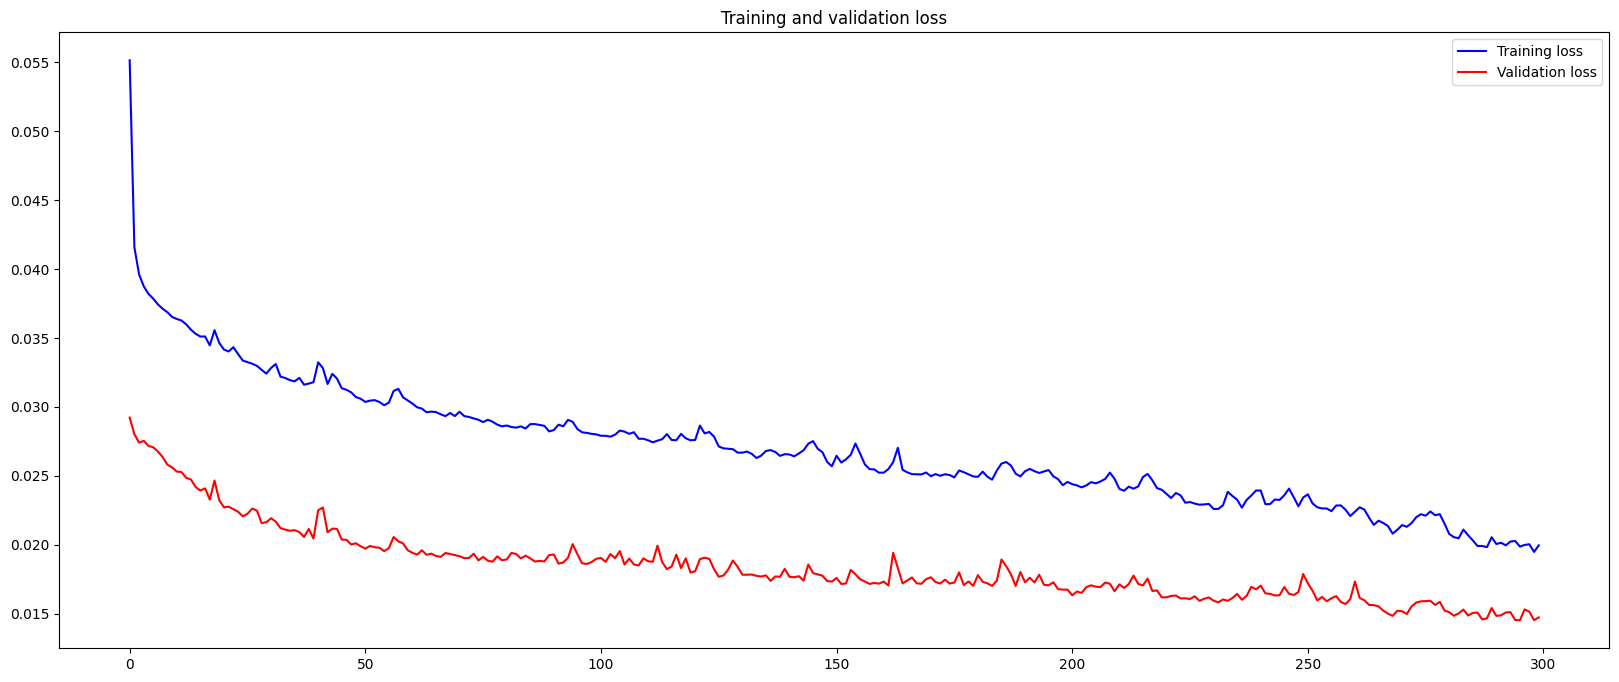

In [22]:
plot_loss(history_conv_lstm)

In [23]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step  


{'mae': np.float32(0.011172578),
 'mse': np.float32(0.0002785083),
 'r2': 0.7511236071586609}

#### Plot predictions

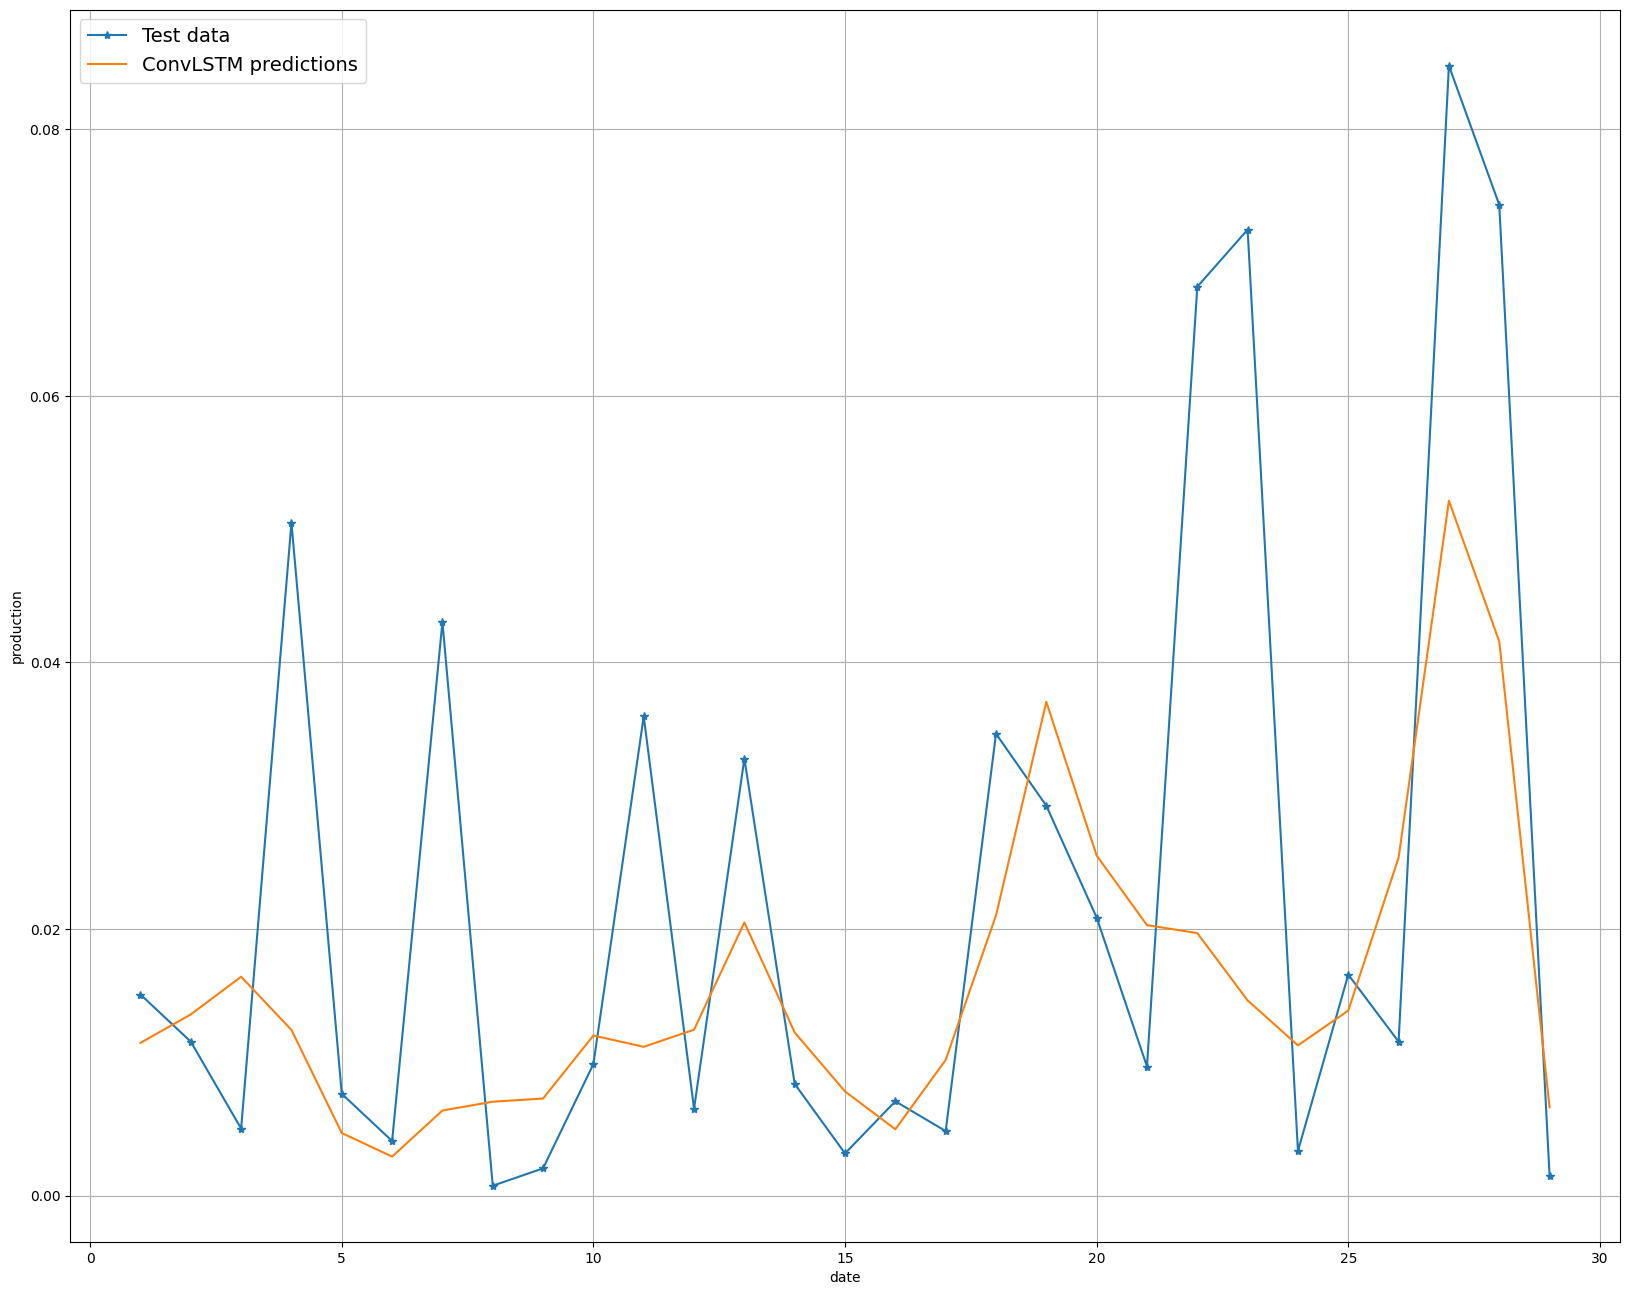

In [24]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)